<a href="https://colab.research.google.com/github/mohamedosamaaly22/Based_Info_Lock/blob/main/HCI_proj_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
%pip install wfdb

In [ ]:
import wfdb
import os
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from joblib import dump
from scipy.signal import butter, filtfilt

import numpy as np
from scipy.signal import find_peaks
import pywt
from scipy.fftpack import dct
from scipy.signal import correlate
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

**1)Data Reading**

In [ ]:
from google.colab import files
import zipfile
import os

# Upload the zip files
uploaded = files.upload()  # Select Data.zip and Data_test.zip

# Unzip the files
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall()


Saving Data.zip to Data.zip


In [ ]:
import os
import wfdb

data_directories = ["/content/Data"]

signals_list = []
fields_list = []
labels_list = []

for data_directory in data_directories:
    for subject_name in os.listdir(data_directory):
        subject_directory = os.path.join(data_directory, subject_name)

        for filename in os.listdir(subject_directory):
            file_name_without_extension = filename.split('.')[0]
            full_file_path = os.path.join(subject_directory, file_name_without_extension)

            print(f"Processing file: {full_file_path}")

            signal_data, meta_fields = wfdb.rdsamp(full_file_path, channels=[1])

            signals_list.append(signal_data)
            fields_list.append(meta_fields)
            labels_list.append(subject_name)

            break  # Optional: remove if you want all files per subject


Processing file: /content/Data/Patient - 237/s0465_re
Processing file: /content/Data/Patient - 214/s0436_re
Processing file: /content/Data/Patient - 238/s0466_re
Processing file: /content/Data/Patient - 260/s0496_re
Processing file: /content/Data/Patient - 263/s0499_re


In [ ]:
print(len(signals_list))

5


In [ ]:
print(len(fields_list[0]))

8


In [ ]:
print((fields_list[0]))

{'fs': 1000, 'sig_len': 120012, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['ii'], 'comments': ['age: 47', 'sex: male', 'ECG date: 17/10/1996', 'Diagnose:', 'Reason for admission: Healthy control', 'Acute infarction (localization): no', 'Former infarction (localization): no', 'Additional diagnoses: no', 'Smoker: unknown', 'Number of coronary vessels involved: unknown', 'Infarction date (acute): n/a', 'Previous infarction (1) date: n/a', 'Previous infarction (2) date: n/a', 'Hemodynamics:', 'Catheterization date: n/a', 'Ventriculography: n/a', 'Chest X-ray: n/a', 'Peripheral blood Pressure (syst/diast): n/a', 'Pulmonary artery pressure (at rest) (syst/diast): n/a', 'Pulmonary artery pressure (at rest) (mean): n/a', 'Pulmonary capillary wedge pressure (at rest): n/a', 'Cardiac output (at rest): n/a', 'Cardiac index (at rest): n/a', 'Stroke volume index (at rest): n/a', 'Pulmonary artery pressure (laod) (syst/diast): n/a', 'Pulmonary artery pressure (la

In [ ]:
print((signals_list[0]))

[[-0.7405]
 [-0.7385]
 [-0.7375]
 ...
 [ 0.4375]
 [ 0.4365]
 [ 0.437 ]]


In [ ]:
print(len(labels_list))
print(labels_list)

5
['Patient - 237', 'Patient - 214', 'Patient - 238', 'Patient - 260', 'Patient - 263']


**Some Plots**

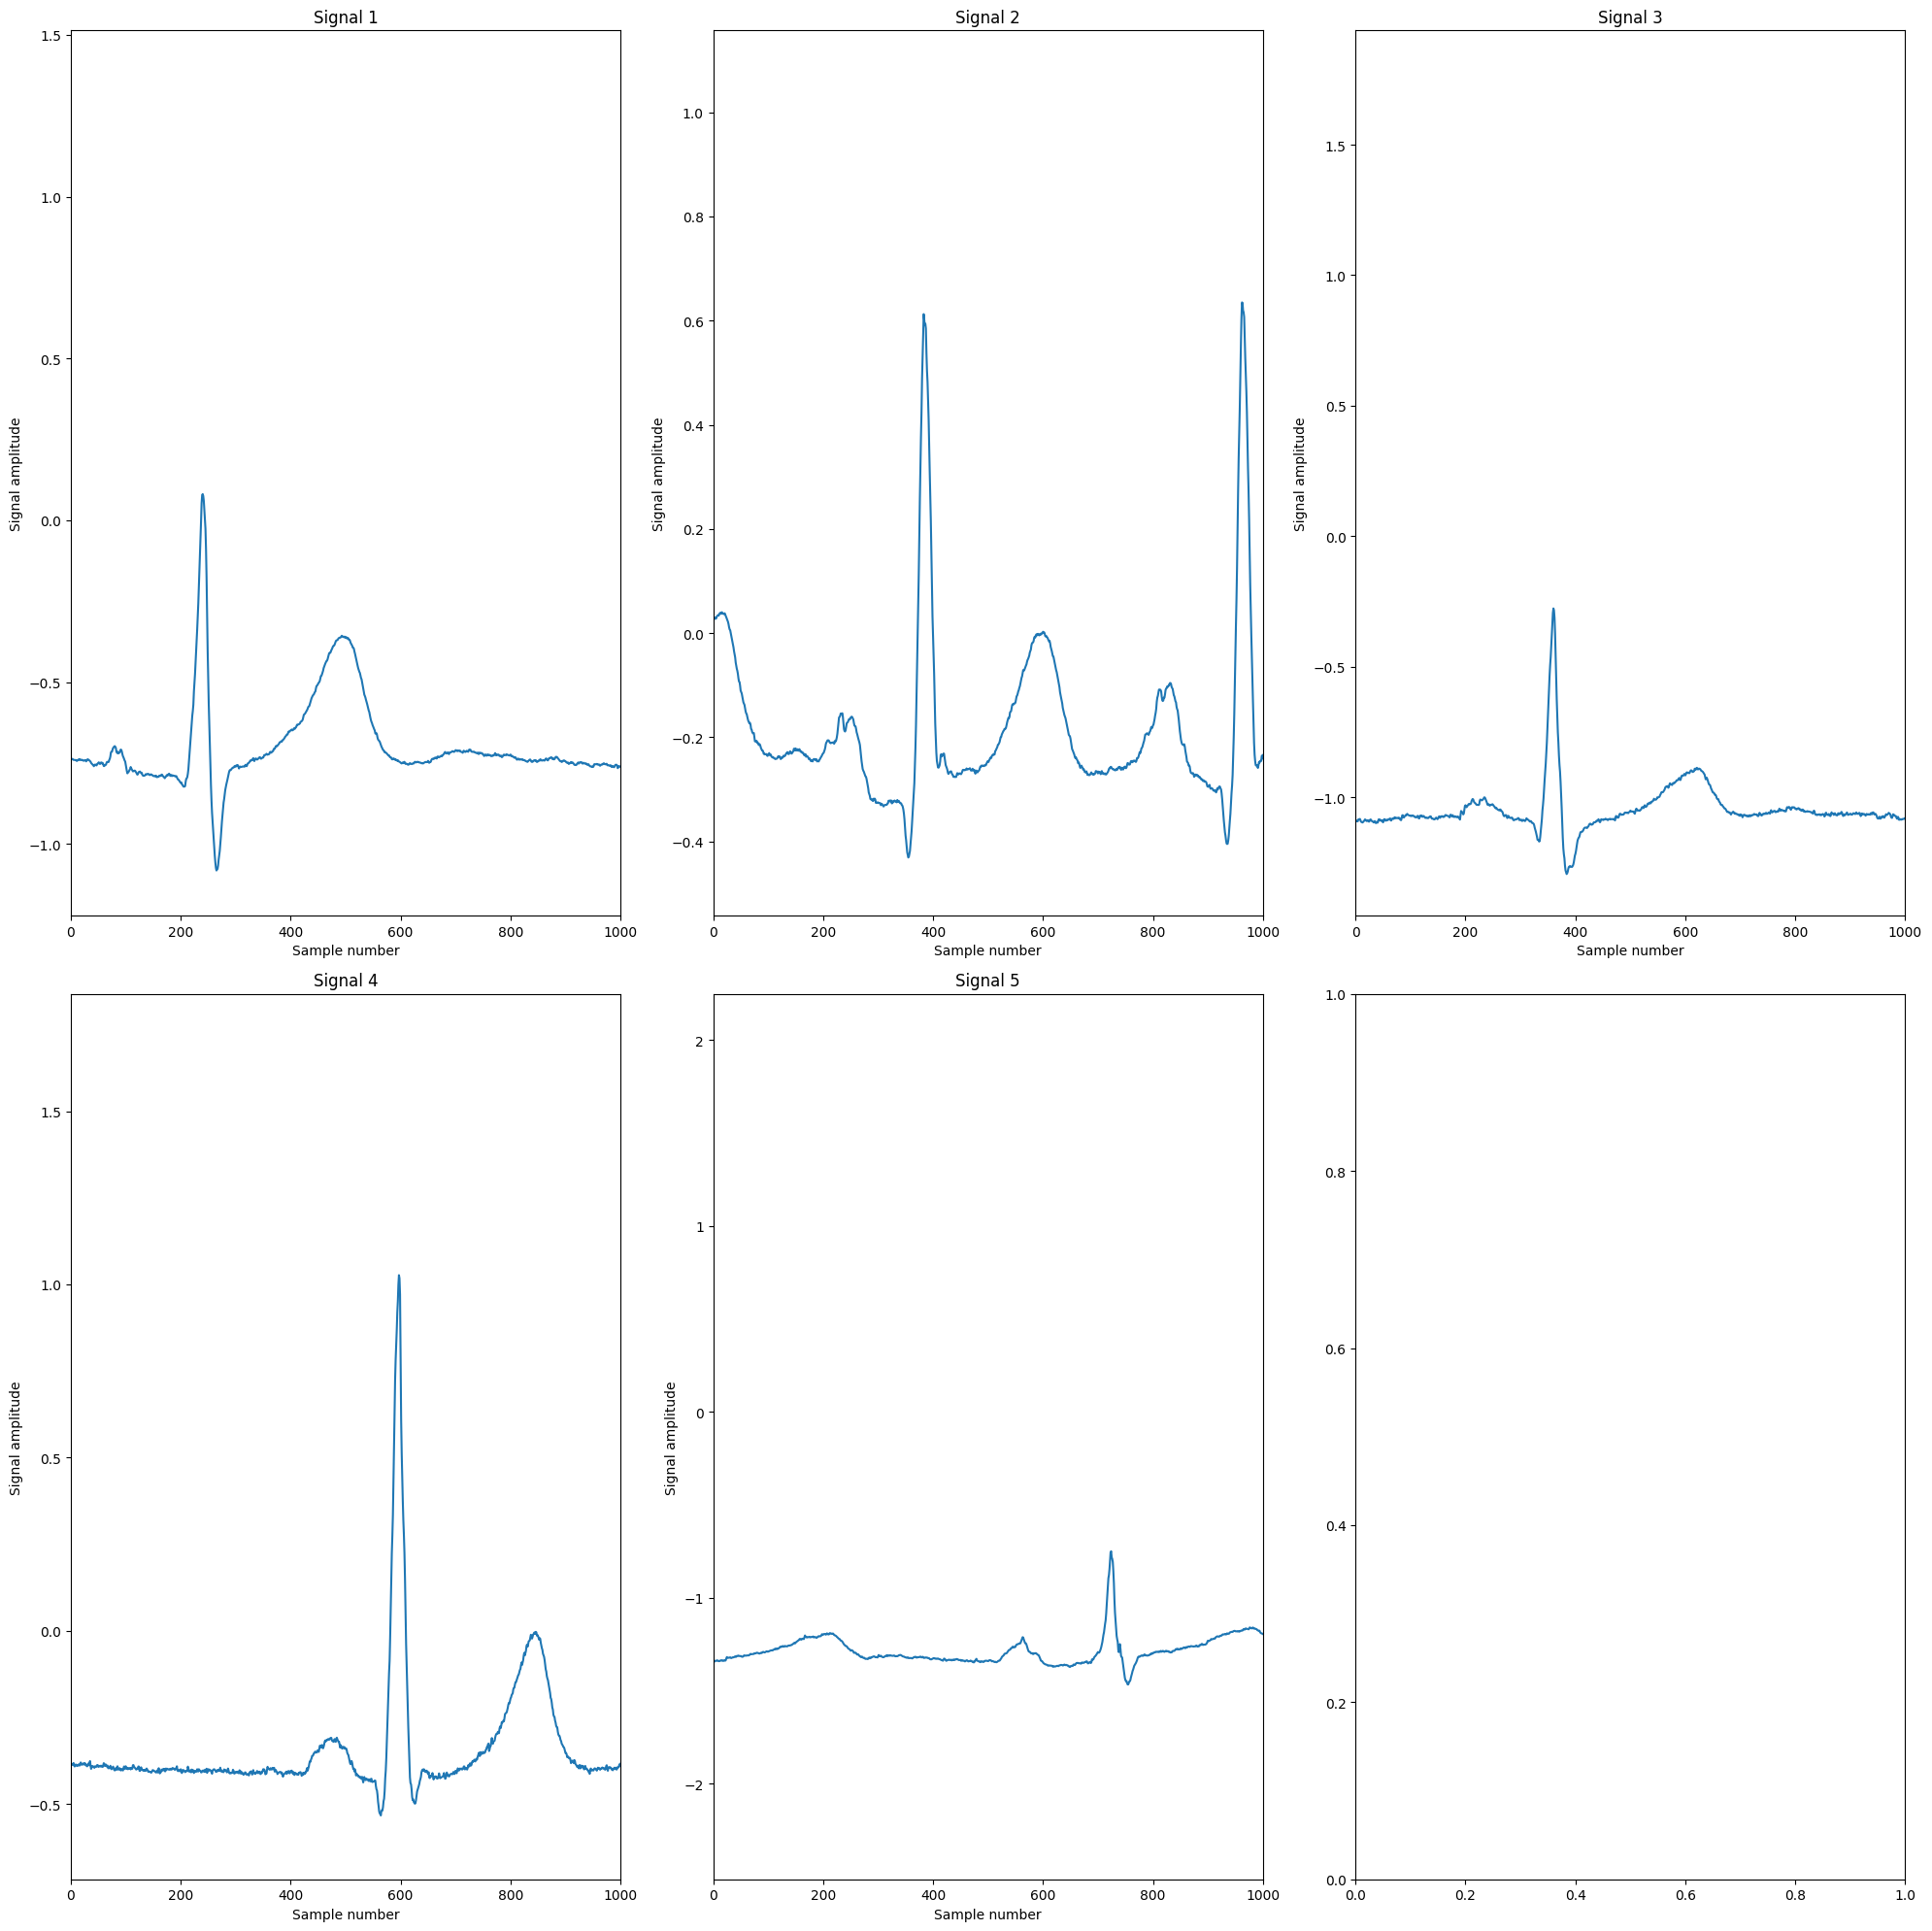

In [ ]:
start_sec, end_sec = 0, 1

fig, axs = plt.subplots(2, 3, figsize=(20, 20))

# Flatten the axs array for easier iteration if needed, or directly iterate using row/col limits
axs = axs.flatten() # Flatten the 2x3 array into a 1D array of 6 axes

# Iterate only up to the number of available axes or the number of signals, whichever is smaller
for idx, signal_data in enumerate(signals_list[:len(axs)]): # Limit the loop to the number of axes

    sampling_frequency = fields_list[idx]['fs']

    start_sample = int(start_sec * sampling_frequency)
    end_sample = int(end_sec * sampling_frequency)

    # Access the flattened axes using idx
    current_ax = axs[idx]

    current_ax.plot(signal_data)

    current_ax.set(xlabel='Sample number', ylabel='Signal amplitude',
                   title=f'Signal {idx + 1}')

    current_ax.set_xlim(start_sample, end_sample)

plt.tight_layout()
plt.show()

**2)Pre-Processing & Segmentation**

**Band-pass-filter**

Filtered Signal 1:
[-5.09124027e-03 -5.06865135e-03 -5.06792741e-03 -5.10371710e-03
 -5.18201295e-03 -5.30006602e-03 -5.44932101e-03 -5.61882952e-03
 -5.79707602e-03 -5.97281705e-03 -6.13600340e-03 -6.27904933e-03
 -6.39905015e-03 -6.49992359e-03 -6.59170982e-03 -6.68667650e-03
 -6.79475225e-03 -6.92126891e-03 -7.06756921e-03 -7.23250100e-03
 -7.41363192e-03 -7.60794854e-03 -7.81238835e-03 -8.02524567e-03
 -8.24845124e-03 -8.48944892e-03 -8.76103795e-03 -9.07915447e-03
 -9.46155161e-03 -9.92939884e-03 -1.05080441e-02 -1.12221417e-02
 -1.20875066e-02 -1.31057613e-02 -1.42633702e-02 -1.55328801e-02
 -1.68749116e-02 -1.82409875e-02 -1.95778934e-02 -2.08333718e-02
 -2.19614579e-02 -2.29262282e-02 -2.37046766e-02 -2.42896303e-02
 -2.46903529e-02 -2.49282144e-02 -2.50309903e-02 -2.50313908e-02
 -2.49685791e-02 -2.48865697e-02 -2.48279963e-02 -2.48269295e-02
 -2.49037495e-02 -2.50646336e-02 -2.53058174e-02 -2.56168242e-02
 -2.59777098e-02 -2.63535998e-02 -2.66928464e-02 -2.69294069e-02
 -2.69

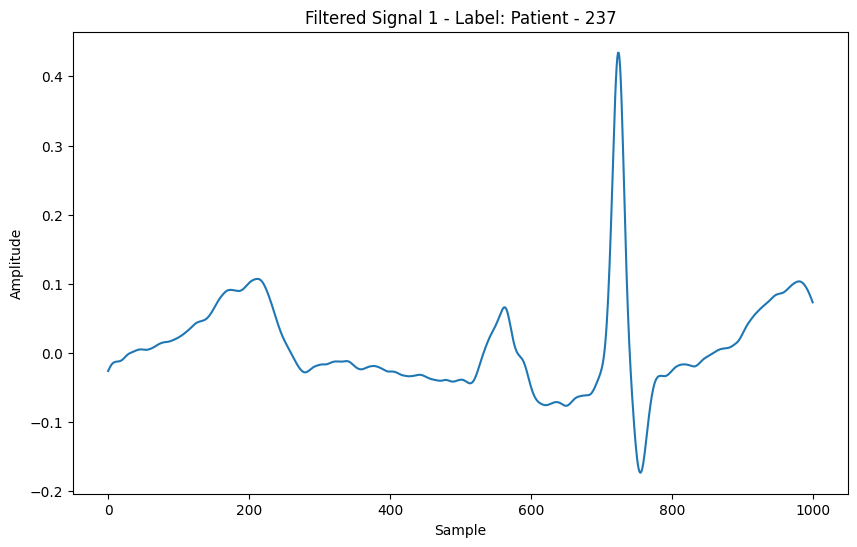

Filtered Signal 2:
[ 1.04679983e-01  1.06231951e-01  1.07792333e-01  1.09358666e-01
  1.10929065e-01  1.12501287e-01  1.14070628e-01  1.15627384e-01
  1.17156997e-01  1.18642483e-01  1.20065591e-01  1.21405727e-01
  1.22639129e-01  1.23740669e-01  1.24686524e-01  1.25454104e-01
  1.26020127e-01  1.26360746e-01  1.26453222e-01  1.26275777e-01
  1.25806062e-01  1.25021421e-01  1.23902201e-01  1.22435389e-01
  1.20615178e-01  1.18441077e-01  1.15916255e-01  1.13047151e-01
  1.09843901e-01  1.06319928e-01  1.02489414e-01  9.83647941e-02
  9.39578084e-02  8.92828006e-02  8.43581583e-02  7.92060673e-02
  7.38525812e-02  6.83275787e-02  6.26643981e-02  5.68995011e-02
  5.10719309e-02  4.52224343e-02  3.93908464e-02  3.36116088e-02
  2.79113346e-02  2.23107240e-02  1.68276170e-02  1.14768260e-02
  6.26806422e-03  1.20733495e-03 -3.69964647e-03 -8.44848318e-03
 -1.30394093e-02 -1.74760924e-02 -2.17618885e-02 -2.58994283e-02
 -2.98928373e-02 -3.37477323e-02 -3.74680618e-02 -4.10542771e-02
 -4.45

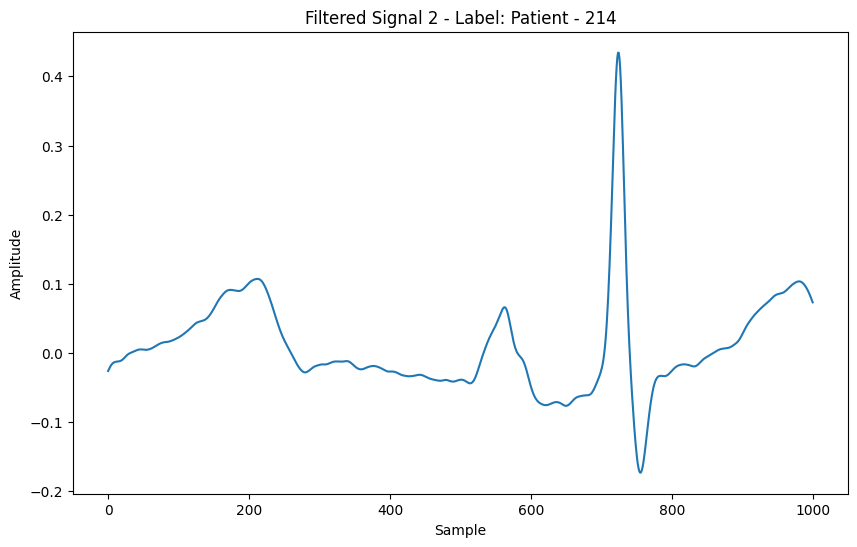

Filtered Signal 3:
[-1.20730430e-02 -1.20324579e-02 -1.19946407e-02 -1.19711747e-02
 -1.19787464e-02 -1.20375820e-02 -1.21669831e-02 -1.23770042e-02
 -1.26614400e-02 -1.29955930e-02 -1.33395492e-02 -1.36482930e-02
 -1.38844721e-02 -1.40272087e-02 -1.40755274e-02 -1.40469103e-02
 -1.39715681e-02 -1.38843636e-02 -1.38158373e-02 -1.37851513e-02
 -1.37996108e-02 -1.38605803e-02 -1.39692825e-02 -1.41273711e-02
 -1.43351417e-02 -1.45937090e-02 -1.49095253e-02 -1.52926911e-02
 -1.57475553e-02 -1.62643793e-02 -1.68193582e-02 -1.73807353e-02
 -1.79147278e-02 -1.83899522e-02 -1.87815872e-02 -1.90723687e-02
 -1.92488898e-02 -1.92999675e-02 -1.92218501e-02 -1.90234839e-02
 -1.87261769e-02 -1.83622281e-02 -1.79730280e-02 -1.75998620e-02
 -1.72713599e-02 -1.69986928e-02 -1.67783336e-02 -1.65970323e-02
 -1.64372527e-02 -1.62805479e-02 -1.61101751e-02 -1.59175933e-02
 -1.57073376e-02 -1.54908346e-02 -1.52744821e-02 -1.50552640e-02
 -1.48260982e-02 -1.45821480e-02 -1.43220966e-02 -1.40473794e-02
 -1.37

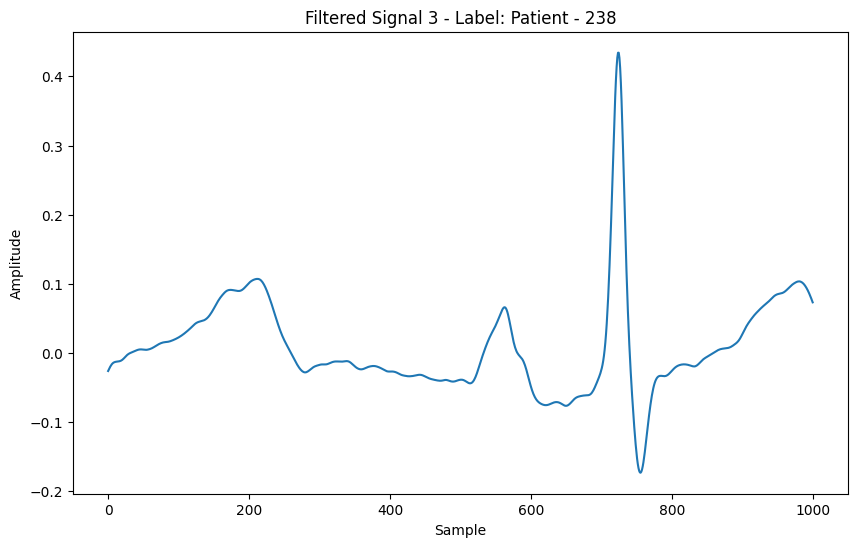

Filtered Signal 4:
[ 1.04050174e-02  9.80538429e-03  9.22616357e-03  8.68376691e-03
  8.18889017e-03  7.74910428e-03  7.37428361e-03  7.07790319e-03
  6.87082481e-03  6.75642280e-03  6.73360071e-03  6.80134036e-03
  6.95762393e-03  7.19469570e-03  7.49691605e-03  7.84355274e-03
  8.21263638e-03  8.58098300e-03  8.92322319e-03  9.21659730e-03
  9.44754867e-03  9.61083512e-03  9.70351466e-03  9.72203453e-03
  9.66418207e-03  9.53233173e-03  9.33406193e-03  9.08104743e-03
  8.78839214e-03  8.47137619e-03  8.13855392e-03  7.78683446e-03
  7.40441537e-03  6.97983259e-03  6.50790157e-03  5.99139378e-03
  5.44684436e-03  4.90765193e-03  4.41128164e-03  3.98308054e-03
  3.63508925e-03  3.37390403e-03  3.20437813e-03  3.12784333e-03
  3.13944574e-03  3.22817566e-03  3.37937938e-03  3.57620996e-03
  3.80063391e-03  4.03772567e-03  4.28029291e-03  4.52775855e-03
  4.78117392e-03  5.04003797e-03  5.30163418e-03  5.56105352e-03
  5.81053399e-03  6.03848518e-03  6.22892399e-03  6.35998976e-03
  6.40

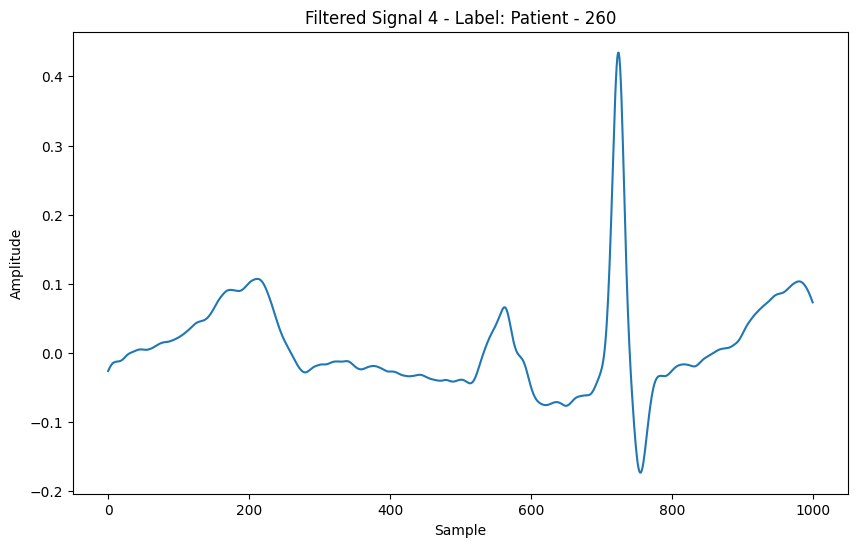

Filtered Signal 5:
[-2.59856088e-02 -2.37736525e-02 -2.16576027e-02 -1.97116192e-02
 -1.79899808e-02 -1.65247360e-02 -1.53268451e-02 -1.43895352e-02
 -1.36910431e-02 -1.31961729e-02 -1.28601847e-02 -1.26359161e-02
 -1.24803372e-02 -1.23572100e-02 -1.22355299e-02 -1.20859662e-02
 -1.18780860e-02 -1.15802191e-02 -1.11629952e-02 -1.06049179e-02
 -9.89659095e-03 -9.04226065e-03 -8.06030720e-03 -6.98530794e-03
 -5.86871439e-03 -4.76996459e-03 -3.73952242e-03 -2.80778529e-03
 -1.98654571e-03 -1.27506703e-03 -6.63668946e-04 -1.35370824e-04
  3.32660841e-04  7.66200914e-04  1.18849518e-03  1.61516891e-03
  2.05303320e-03  2.50170685e-03  2.95491209e-03  3.40132001e-03
  3.82714588e-03  4.21948037e-03  4.56647274e-03  4.85510172e-03
  5.07188309e-03  5.20713104e-03  5.25853561e-03  5.23268351e-03
  5.14474835e-03  5.01598367e-03  4.87070733e-03  4.73467740e-03
  4.63374856e-03  4.59031145e-03  4.61802322e-03  4.71869751e-03
  4.88431739e-03  5.10368816e-03  5.36933782e-03  5.67970789e-03
  6.03

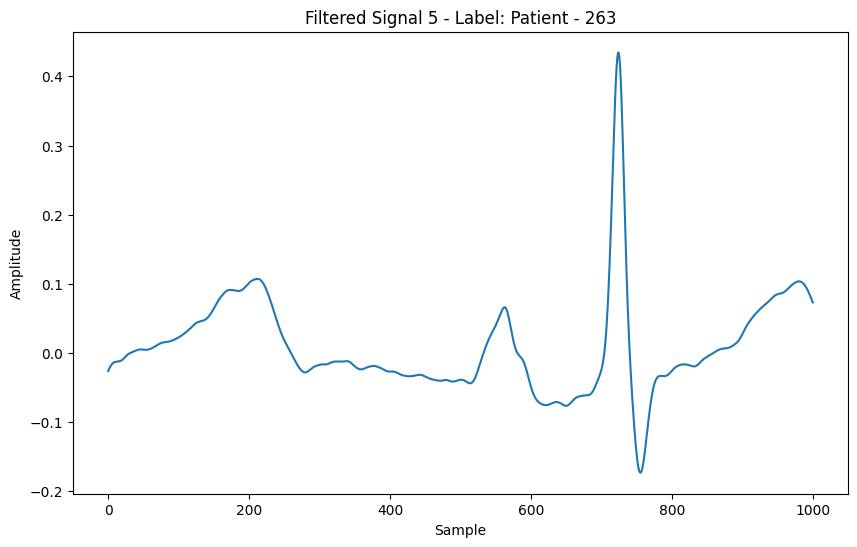

In [ ]:
filtered_signals = []
filtered_labels = []

low_cut = 1.0
high_cut = 40.0
order = 2

for i in range(len(signals_list)):
    fs = fields_list[i]['fs']
    nyq = 0.5 * fs
    low = low_cut / nyq
    high = high_cut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, signals_list[i][:, 0])
    filtered_signals.append(filtered)
    filtered_labels.append(labels_list[i])

for i, signal in enumerate(filtered_signals):
    print(f"Filtered Signal {i + 1}:")
    print(signal[:1000])

    # Plot
    print(f"Filtered Signal {i + 1} (Label: {labels_list[i]})")
    plt.figure(figsize=(10, 6))
    plt.plot(filtered[:1000])
    plt.title(f'Filtered Signal {i + 1} - Label: {labels_list[i]}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()


**Segmentation**

In [ ]:
def detect_r_peaks(ecg_signal, fs=1000):
    peaks, _ = find_peaks(ecg_signal, height=0.6 * np.max(ecg_signal), distance=fs // 2)
    return peaks


def segment_ecg(ecg_signal, r_peaks, label):
    segments_with_labels = []
    for i in range(len(r_peaks) - 1):
        start = r_peaks[i]
        end = r_peaks[i + 1]
        segment = ecg_signal[start:end]
        segments_with_labels.append((segment, label))
    return segments_with_labels

all_segments_with_labels = []
for i, ecg_signal in enumerate(filtered_signals):
    fs = fields_list[i]['fs']
    r_peaks = detect_r_peaks(ecg_signal, fs)
    segments_with_labels = segment_ecg(ecg_signal, r_peaks, filtered_labels[i])
    all_segments_with_labels.extend(segments_with_labels)

# Now plot the segmented signals
# for i, (segment, label) in enumerate(all_segments_with_labels):
#     plt.figure(figsize=(6, 4))
#     plt.plot(segment)
#     plt.title(f"Segment {i+1} - Label: {label}")
#     plt.xlabel("Sample")
#     plt.ylabel("Amplitude")
#     plt.show()


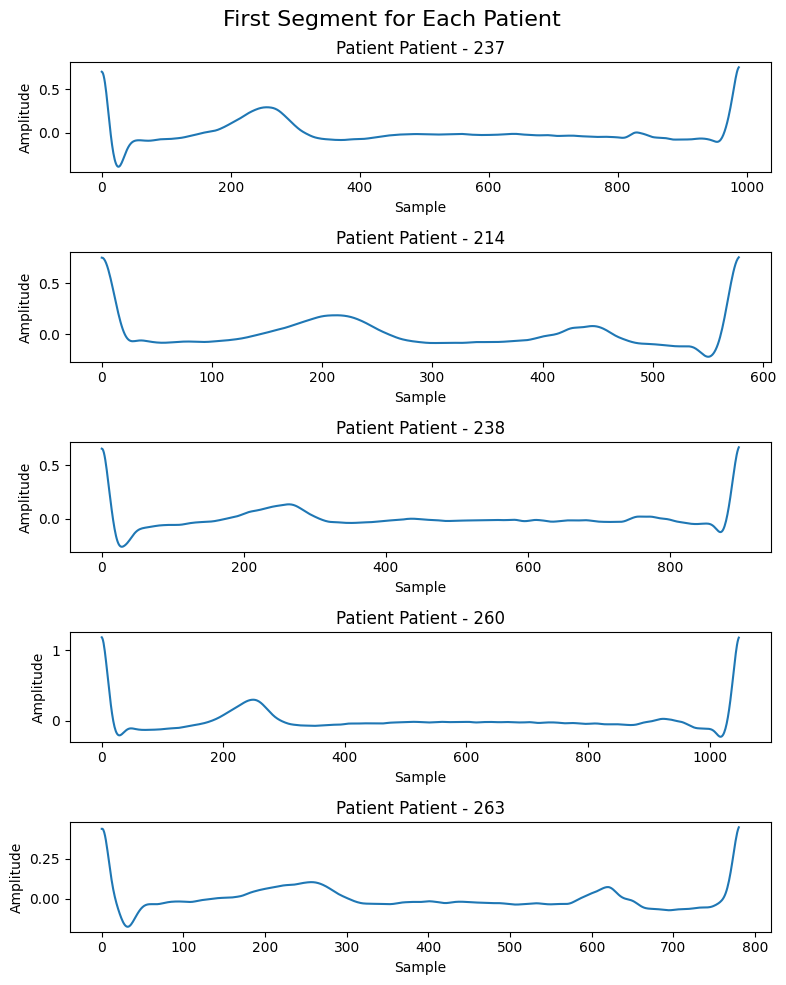

In [ ]:
first_segments = {}

for segment, label in all_segments_with_labels:
    if label not in first_segments:
        first_segments[label] = segment

# Plotting the segments
fig, axs = plt.subplots(len(first_segments), 1, figsize=(8, 10))
fig.suptitle("First Segment for Each Patient", fontsize=16)

for i, (label, segment) in enumerate(first_segments.items()):
    axs[i].plot(segment)
    axs[i].set_title(f"Patient {label}")
    axs[i].set_xlabel("Sample")
    axs[i].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter

label_counts = Counter(label for _, label in all_segments_with_labels)

for label, count in label_counts.items():
    print(f"Label '{label}': {count} segments")


Label 'Patient - 237': 122 segments
Label 'Patient - 214': 195 segments
Label 'Patient - 238': 156 segments
Label 'Patient - 260': 122 segments
Label 'Patient - 263': 152 segments


**Extracting Features**

**Non-Fiducial**

In [ ]:
print(len(all_segments_with_labels))

747


**DWT , AC+DCT**

In [ ]:
def extract_dwt_features(signal, wavelet='db4', level=6):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = []
    for c in coeffs:
        features.append(np.mean(c))
        features.append(np.std(c))
    return np.array(features)

def extract_ac_dct_features(signal, num_coeffs=20):
    ac = correlate(signal, signal, mode='full')
    mid = len(ac) // 2
    ac = ac[mid:]
    dct_vals = dct(ac, norm='ortho')
    return dct_vals[:num_coeffs]


In [ ]:
dwt_features_all = []
ac_dct_features_all = []

for seg, label in all_segments_with_labels:



    dwt_feat = extract_dwt_features(seg)
    ac_dct_feat = extract_ac_dct_features(seg)


    dwt_features_all.append((dwt_feat, label))
    ac_dct_features_all.append((ac_dct_feat, label))

dwt_features_all = np.array(dwt_features_all, dtype=object)
ac_dct_features_all = np.array(ac_dct_features_all, dtype=object)


for i in range(len(dwt_features_all)):
    print(f"Segment {i+1} - Label: {dwt_features_all[i][1]}")
    print(f"DWT Features: {dwt_features_all[i][0]}")

for i in range(len(ac_dct_features_all)):
    print(f"Segment {i+1} - Label: {ac_dct_features_all[i][1]}")
    print(f"AC+DCT Features: {ac_dct_features_all[i][0]}")

Segment 1 - Label: Patient - 237
DWT Features: [ 1.55214710e+00  2.47948344e+00  1.82927970e-02  7.24280353e-01
 -9.67722684e-03  3.60497908e-01  1.40144021e-04  6.99194354e-02
 -1.00075191e-03  1.63706819e-02 -2.69692745e-05  6.80471324e-04
 -6.50681575e-07  7.48666530e-05]
Segment 2 - Label: Patient - 237
DWT Features: [ 1.70988827e+00  2.68543458e+00  2.16232322e-02  6.45541945e-01
 -9.80554130e-03  3.31557915e-01 -4.05697750e-04  7.93708177e-02
 -9.87498446e-04  1.79639823e-02 -2.12751497e-05  1.31027830e-03
 -6.81310608e-07  5.82055818e-05]
Segment 3 - Label: Patient - 237
DWT Features: [ 1.73829293e+00  2.71573504e+00  1.99639047e-02  4.76645466e-01
 -1.22172821e-02  2.78860601e-01  2.31929182e-04  6.74616805e-02
 -1.09018915e-03  1.70769561e-02 -1.58408064e-05  8.33048311e-04
 -7.37993987e-07  4.25260712e-05]
Segment 4 - Label: Patient - 237
DWT Features: [ 1.85705361e+00  2.78163679e+00  1.54835758e-02  4.66440728e-01
 -1.41182539e-02  2.87997363e-01 -1.31451659e-04  7.62615297

In [ ]:
print(len(ac_dct_features_all))
print(len(ac_dct_features_all[0][0]))

747
20


**3)Compare between using AC\DCT and wavelet coefficients for ECG band.**

In [ ]:

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
X_dwt = np.array([features for features, label in dwt_features_all])
y_dwt = np.array([label for features, label in dwt_features_all])


X_ac_dct = np.array([features for features, label in ac_dct_features_all])
y_ac_dct = np.array([label for features, label in ac_dct_features_all])

label_encoder = LabelEncoder()
y_dwt_encoded = label_encoder.fit_transform(y_dwt)
y_ac_dct_encoded = label_encoder.transform(y_ac_dct)

X_train_dwt, X_test_dwt, y_train_dwt, y_test_dwt = train_test_split(X_dwt, y_dwt_encoded, test_size=0.2, random_state=42)
X_train_ac_dct, X_test_ac_dct, y_train_ac_dct, y_test_ac_dct = train_test_split(X_ac_dct, y_ac_dct_encoded, test_size=0.2, random_state=42)


dwt_classifier = LogisticRegression(max_iter=1000, random_state=42)
ac_dct_classifier = LogisticRegression(max_iter=1000, random_state=42)

dwt_classifier.fit(X_train_dwt, y_train_dwt)
ac_dct_classifier.fit(X_train_ac_dct, y_train_ac_dct)


y_pred_dwt = dwt_classifier.predict(X_test_dwt)
y_pred_ac_dct = ac_dct_classifier.predict(X_test_ac_dct)


acc_dwt = accuracy_score(y_test_dwt, y_pred_dwt)
acc_ac_dct = accuracy_score(y_test_ac_dct, y_pred_ac_dct)

print(f"DWT Classifier Accuracy: {acc_dwt * 100:.2f}%")
print(f"AC+DCT Classifier Accuracy: {acc_ac_dct * 100:.2f}%")

print("\nConfusion Matrix for DWT Classifier:")
print(confusion_matrix(y_test_dwt, y_pred_dwt))

print("\nClassification Report for DWT Classifier:")
print(classification_report(y_test_dwt, y_pred_dwt, target_names=label_encoder.classes_))

print("\nConfusion Matrix for AC+DCT Classifier:")
print(confusion_matrix(y_test_ac_dct, y_pred_ac_dct))

print("\nClassification Report for AC+DCT Classifier:")
print(classification_report(y_test_ac_dct, y_pred_ac_dct, target_names=label_encoder.classes_))


DWT Classifier Accuracy: 97.33%
AC+DCT Classifier Accuracy: 100.00%

Confusion Matrix for DWT Classifier:
[[33  0  0  0  0]
 [ 0 30  0  0  0]
 [ 3  1 34  0  0]
 [ 0  0  0 19  0]
 [ 0  0  0  0 30]]

Classification Report for DWT Classifier:
               precision    recall  f1-score   support

Patient - 214       0.92      1.00      0.96        33
Patient - 237       0.97      1.00      0.98        30
Patient - 238       1.00      0.89      0.94        38
Patient - 260       1.00      1.00      1.00        19
Patient - 263       1.00      1.00      1.00        30

     accuracy                           0.97       150
    macro avg       0.98      0.98      0.98       150
 weighted avg       0.98      0.97      0.97       150


Confusion Matrix for AC+DCT Classifier:
[[33  0  0  0  0]
 [ 0 30  0  0  0]
 [ 0  0 38  0  0]
 [ 0  0  0 19  0]
 [ 0  0  0  0 30]]

Classification Report for AC+DCT Classifier:
               precision    recall  f1-score   support

Patient - 214       1.00    

**Classification**

**SVM using ac_dct (Grid search is used for finding the best param)**

In [ ]:
X_ac_dct = np.array([feat for feat, label in ac_dct_features_all])
y_ac_dct = np.array([label for feat, label in ac_dct_features_all])

X_train_ac_dct, X_test_ac_dct, y_train_ac_dct, y_test_ac_dct = train_test_split(
    X_ac_dct, y_ac_dct, test_size=0.2, random_state=42
)


svm_pipeline = make_pipeline(StandardScaler(), SVC(probability=True))


param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto']
}


grid_search = GridSearchCV(
    svm_pipeline, param_grid, cv=5, scoring='accuracy',
    verbose=2, n_jobs=-1
)
grid_search.fit(X_train_ac_dct, y_train_ac_dct)


print("\n📊 Test Accuracy for Each GridSearch Combination:")
for i, params in enumerate(grid_search.cv_results_['params']):

    model = make_pipeline(StandardScaler(), SVC(
        C=params['svc__C'],
        kernel=params['svc__kernel'],
        gamma=params['svc__gamma'],
        probability=True
    ))
    model.fit(X_train_ac_dct, y_train_ac_dct)
    y_pred = model.predict(X_test_ac_dct)
    acc = accuracy_score(y_test_ac_dct, y_pred)
    print(f"Testing: C={params['svc__C']}, kernel={params['svc__kernel']}, gamma={params['svc__gamma']} -> Accuracy: {acc * 100:.2f}%")

best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_ac_dct)
acc_best = accuracy_score(y_test_ac_dct, y_pred_best)





print("\n✅ Best SVM Accuracy ac_dct: {:.2f}%".format(acc_best * 100))
print("🔧 Best Parameters:", grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test_ac_dct, y_pred_best))


Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 Test Accuracy for Each GridSearch Combination:
Testing: C=0.1, kernel=linear, gamma=scale -> Accuracy: 100.00%
Testing: C=0.1, kernel=rbf, gamma=scale -> Accuracy: 100.00%
Testing: C=0.1, kernel=linear, gamma=auto -> Accuracy: 100.00%
Testing: C=0.1, kernel=rbf, gamma=auto -> Accuracy: 100.00%
Testing: C=1, kernel=linear, gamma=scale -> Accuracy: 100.00%
Testing: C=1, kernel=rbf, gamma=scale -> Accuracy: 100.00%
Testing: C=1, kernel=linear, gamma=auto -> Accuracy: 100.00%
Testing: C=1, kernel=rbf, gamma=auto -> Accuracy: 100.00%
Testing: C=10, kernel=linear, gamma=scale -> Accuracy: 100.00%
Testing: C=10, kernel=rbf, gamma=scale -> Accuracy: 100.00%
Testing: C=10, kernel=linear, gamma=auto -> Accuracy: 100.00%
Testing: C=10, kernel=rbf, gamma=auto -> Accuracy: 100.00%

✅ Best SVM Accuracy ac_dct: 100.00%
🔧 Best Parameters: {'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

📊 Classification Report:
           

**SVM using dwt Grid search is used in finding the best param**

In [ ]:
X_wdt = np.array([feat for feat, label in dwt_features_all])
y_dwt = np.array([label for feat, label in dwt_features_all])

X_train_dwt, X_test_dwt, y_train_dwt, y_test_dwt = train_test_split(
    X_wdt, y_dwt, test_size=0.2, random_state=42
)

svm_pipeline = make_pipeline(StandardScaler(), SVC(probability=True))

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(
    svm_pipeline, param_grid, cv=5, scoring='accuracy',
    verbose=2, n_jobs=-1
)
grid_search.fit(X_train_dwt, y_train_dwt)

print("\n📊 Test Accuracy for Each GridSearch Combination:")
for i, params in enumerate(grid_search.cv_results_['params']):

    model = make_pipeline(StandardScaler(), SVC(
        C=params['svc__C'],
        kernel=params['svc__kernel'],
        gamma=params['svc__gamma'],
        probability=True
    ))
    model.fit(X_train_dwt, y_train_dwt)
    y_pred = model.predict(X_test_dwt)
    acc = accuracy_score(y_test_dwt, y_pred)
    print(f"Testing: C={params['svc__C']}, kernel={params['svc__kernel']}, gamma={params['svc__gamma']} -> Accuracy: {acc * 100:.2f}%")


best_svm_dwt = grid_search.best_estimator_
y_pred_dwt_ = best_svm_dwt.predict(X_test_dwt)
acc = accuracy_score(y_test_dwt, y_pred_dwt_)





print("✅ Best SVM Accuracy using dwt : {:.2f}%".format(acc * 100))
print("🔧 Best Parameters:", grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test_dwt, y_pred_dwt_))


Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 Test Accuracy for Each GridSearch Combination:
Testing: C=0.1, kernel=linear, gamma=scale -> Accuracy: 100.00%
Testing: C=0.1, kernel=rbf, gamma=scale -> Accuracy: 97.33%
Testing: C=0.1, kernel=linear, gamma=auto -> Accuracy: 100.00%
Testing: C=0.1, kernel=rbf, gamma=auto -> Accuracy: 97.33%
Testing: C=1, kernel=linear, gamma=scale -> Accuracy: 100.00%
Testing: C=1, kernel=rbf, gamma=scale -> Accuracy: 99.33%
Testing: C=1, kernel=linear, gamma=auto -> Accuracy: 100.00%
Testing: C=1, kernel=rbf, gamma=auto -> Accuracy: 99.33%
Testing: C=10, kernel=linear, gamma=scale -> Accuracy: 100.00%
Testing: C=10, kernel=rbf, gamma=scale -> Accuracy: 100.00%
Testing: C=10, kernel=linear, gamma=auto -> Accuracy: 100.00%
Testing: C=10, kernel=rbf, gamma=auto -> Accuracy: 100.00%
✅ Best SVM Accuracy using dwt : 100.00%
🔧 Best Parameters: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

📊 Classification Report:
              

**LOGISTIC Regression using ac_dct**

In [ ]:
X_ac_dct_log = np.array([feat for feat, label in ac_dct_features_all])
y_ac_dct_log = np.array([label for feat, label in ac_dct_features_all])


X_train_ac_dct_log, X_test_ac_dct_log, y_train_ac_dct_log, y_test_ac_dct_log = train_test_split(
    X_ac_dct_log, y_ac_dct_log, test_size=0.2, random_state=42
)

logreg_pipeline_log_ac_dct = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logreg_pipeline_log_ac_dct.fit(X_train_ac_dct_log, y_train_ac_dct_log)

y_pred_logreg_ac_dct = logreg_pipeline_log_ac_dct.predict(X_test_ac_dct_log)
acc_logreg_ac_dct = accuracy_score(y_test_ac_dct_log, y_pred_logreg_ac_dct)

print("✅ Logistic Regression Accuracy using ac_dct :", f"{acc_logreg_ac_dct * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test_ac_dct_log, y_pred_logreg_ac_dct))

✅ Logistic Regression Accuracy using ac_dct : 100.00%

Classification Report:
               precision    recall  f1-score   support

Patient - 214       1.00      1.00      1.00        33
Patient - 237       1.00      1.00      1.00        30
Patient - 238       1.00      1.00      1.00        38
Patient - 260       1.00      1.00      1.00        19
Patient - 263       1.00      1.00      1.00        30

     accuracy                           1.00       150
    macro avg       1.00      1.00      1.00       150
 weighted avg       1.00      1.00      1.00       150



**LOGISTIC Regression using dwt**

In [ ]:
X_wdt_log = np.array([feat for feat, label in dwt_features_all])
y_dwt_log = np.array([label for feat, label in dwt_features_all])


X_train_dwt_log, X_test_dwt_log, y_train_dwt_log, y_test_dwt_log = train_test_split(
    X_wdt_log, y_dwt_log, test_size=0.2, random_state=42
)

logreg_pipeline_log = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logreg_pipeline_log.fit(X_train_dwt_log, y_train_dwt_log)

y_pred_logreg_dwt = logreg_pipeline_log.predict(X_test_dwt_log)
acc_logreg_dwt = accuracy_score(y_test_dwt_log, y_pred_logreg_dwt)

print("✅ Logistic Regression Accuracy using DWT :", f"{acc_logreg_dwt * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test_dwt_log, y_pred_logreg_dwt))


✅ Logistic Regression Accuracy using DWT : 100.00%

Classification Report:
               precision    recall  f1-score   support

Patient - 214       1.00      1.00      1.00        33
Patient - 237       1.00      1.00      1.00        30
Patient - 238       1.00      1.00      1.00        38
Patient - 260       1.00      1.00      1.00        19
Patient - 263       1.00      1.00      1.00        30

     accuracy                           1.00       150
    macro avg       1.00      1.00      1.00       150
 weighted avg       1.00      1.00      1.00       150



In [ ]:
import joblib
joblib.dump(best_svm, "best_svm.pkl")

['best_svm.pkl']

In [ ]:
joblib.dump(best_svm_dwt, "SVM_DWT_MAN.pkl")

['SVM_DWT_MAN.pkl']

In [ ]:
joblib.dump(best_svm_dwt, "SVM_DWT_MAN.pkl")
print("\n💾 Best model saved as 'SVM_DWT_MAN.pkl'")


💾 Best model saved as 'SVM_DWT_MAN.pkl'


In [ ]:
# Save Logistic Regression
joblib.dump(logreg_pipeline_log_ac_dct, "logistic_regression_model.pkl")



['logistic_regression_model.pkl']

In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Example: Assume y_train contains your string labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train_ac_dct)

# Save the encoder to a file
joblib.dump(label_encoder, "label_encoder.pkl")
print("✅ Saved 'label_encoder.pkl'")

✅ Saved 'label_encoder.pkl'


##**UI**

In [ ]:
import wfdb
import os
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from joblib import dump, load
import numpy as np
import pywt
from scipy.fftpack import dct
from scipy.signal import correlate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tkinter as tk
from tkinter import filedialog, messagebox
from collections import Counter
import joblib

In [ ]:
import wfdb
import os
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from joblib import dump, load
import numpy as np
import pywt
from scipy.fftpack import dct
from scipy.signal import correlate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tkinter as tk
from tkinter import filedialog, messagebox
from collections import Counter
import joblib

In [ ]:
# Install WFDB if not installed
!pip install wfdb --quiet

from google.colab import files
import wfdb
import os
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, correlate
from scipy.fftpack import dct
import joblib
from collections import Counter

# --- Upload files (.dat, .hea, .pkl) ---
print("🔼 Please upload .dat, .hea, best_svm.pkl, and label_encoder.pkl files")
uploaded = files.upload()

# --- Load the pretrained model and label encoder ---
best_svm = joblib.load("best_svm.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# --- Functions ---a
def detect_r_peaks(ecg_signal, fs=1000):
    peaks, _ = find_peaks(ecg_signal, height=0.6 * np.max(ecg_signal), distance=fs // 2)
    return peaks

def segment_ecg(ecg_signal, r_peaks, label):
    segments_with_labels = []
    for i in range(len(r_peaks) - 1):
        start = r_peaks[i]
        end = r_peaks[i + 1]
        segment = ecg_signal[start:end]
        segments_with_labels.append((segment, label))
    return segments_with_labels

def extract_ac_dct_features(signal, num_coeffs=20):
    if len(signal) < 2:
        return np.zeros(num_coeffs)
    ac = correlate(signal, signal, mode='full')
    mid = len(ac) // 2
    ac = ac[mid:]
    if len(ac) < num_coeffs:
        padded_ac = np.pad(ac, (0, num_coeffs - len(ac)), 'constant')
        dct_vals = dct(padded_ac, norm='ortho')
    else:
        dct_vals = dct(ac, norm='ortho')
    return dct_vals[:num_coeffs]

# --- Find and process the ECG record ---
dat_files = [f for f in uploaded.keys() if f.endswith(".dat")]

if not dat_files:
    print("❌ No .dat files uploaded.")
else:
    for dat_file in dat_files:
        base_path = dat_file[:-4]
        hea_file = base_path + '.hea'

        if hea_file not in uploaded:
            print(f"❌ Missing .hea file for {dat_file}")
            continue

        print(f"\n📈 Processing file: {dat_file}")

        try:
            record = wfdb.rdrecord(base_path, channels=[1])
            signal = record.p_signal[:, 0]
            fs = record.fs

            # Apply band-pass filter
            low_cut = 1.0
            high_cut = 40.0
            order = 2
            nyq = 0.5 * fs
            low = low_cut / nyq
            high = high_cut / nyq
            b, a = butter(order, [low, high], btype='band')
            filtered = filtfilt(b, a, signal)

            # Detect R-peaks
            r_peaks = detect_r_peaks(filtered, fs)
            if len(r_peaks) < 3:
                print("⚠️ Not enough R-peaks detected.")
                continue

            # Segment ECG
            segments_with_labels = segment_ecg(filtered, r_peaks, "Unknown")
            segments = [seg for seg, _ in segments_with_labels]
            valid_segments = [seg for seg in segments if len(seg) > 0]

            if not valid_segments:
                print("⚠️ No valid ECG segments found.")
                continue

            predictions = []
            for seg in valid_segments:
                feat = extract_ac_dct_features(seg)
                probs = best_svm.predict_proba([feat])[0]
                max_prob = np.max(probs)
                pred_index = np.argmax(probs)
                if max_prob >= 0.7:
                    predictions.append(pred_index)

            if predictions:
                counter = Counter(predictions)
                most_common_index, count = counter.most_common(1)[0]
                percent = (count / len(valid_segments)) * 100
                identified_label = label_encoder.inverse_transform([most_common_index])[0]

                if percent >= 100:
                    print(f"✅ Identified as: {identified_label} ({percent:.1f}% match)")
                else:
                    print(f"❌ Undefined - Highest match: {identified_label} ({percent:.1f}%)")
            else:
                print("❌ Not identified - Low confidence in all segments.")

        except Exception as e:
            print(f"❌ Error processing {dat_file}: {str(e)}")

#Patient - 237  - s0465a

🔼 Please upload .dat, .hea, best_svm.pkl, and label_encoder.pkl files


Saving best_svm.pkl to best_svm (6).pkl
Saving label_encoder.pkl to label_encoder (6).pkl
Saving s0465_re.dat to s0465_re (1).dat
Saving s0465_re.hea to s0465_re (1).hea

📈 Processing file: s0465_re (1).dat
✅ Identified as: Patient - 237 (100.0% match)


In [ ]:
# Install WFDB if not installed
!pip install wfdb --quiet

from google.colab import files
import wfdb
import os
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, correlate
from scipy.fftpack import dct
import joblib
from collections import Counter

# --- Upload files (.dat, .hea, .pkl) ---
print("🔼 Please upload .dat, .hea, best_svm.pkl, and label_encoder.pkl files")
uploaded = files.upload()

# --- Load the pretrained model and label encoder ---
best_svm = joblib.load("best_svm.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# --- Functions ---a
def detect_r_peaks(ecg_signal, fs=1000):
    peaks, _ = find_peaks(ecg_signal, height=0.6 * np.max(ecg_signal), distance=fs // 2)
    return peaks

def segment_ecg(ecg_signal, r_peaks, label):
    segments_with_labels = []
    for i in range(len(r_peaks) - 1):
        start = r_peaks[i]
        end = r_peaks[i + 1]
        segment = ecg_signal[start:end]
        segments_with_labels.append((segment, label))
    return segments_with_labels

def extract_ac_dct_features(signal, num_coeffs=20):
    if len(signal) < 2:
        return np.zeros(num_coeffs)
    ac = correlate(signal, signal, mode='full')
    mid = len(ac) // 2
    ac = ac[mid:]
    if len(ac) < num_coeffs:
        padded_ac = np.pad(ac, (0, num_coeffs - len(ac)), 'constant')
        dct_vals = dct(padded_ac, norm='ortho')
    else:
        dct_vals = dct(ac, norm='ortho')
    return dct_vals[:num_coeffs]

# --- Find and process the ECG record ---
dat_files = [f for f in uploaded.keys() if f.endswith(".dat")]

if not dat_files:
    print("❌ No .dat files uploaded.")
else:
    for dat_file in dat_files:
        base_path = dat_file[:-4]
        hea_file = base_path + '.hea'

        if hea_file not in uploaded:
            print(f"❌ Missing .hea file for {dat_file}")
            continue

        print(f"\n📈 Processing file: {dat_file}")

        try:
            record = wfdb.rdrecord(base_path, channels=[1])
            signal = record.p_signal[:, 0]
            fs = record.fs

            # Apply band-pass filter
            low_cut = 1.0
            high_cut = 40.0
            order = 2
            nyq = 0.5 * fs
            low = low_cut / nyq
            high = high_cut / nyq
            b, a = butter(order, [low, high], btype='band')
            filtered = filtfilt(b, a, signal)

            # Detect R-peaks
            r_peaks = detect_r_peaks(filtered, fs)
            if len(r_peaks) < 3:
                print("⚠️ Not enough R-peaks detected.")
                continue

            # Segment ECG
            segments_with_labels = segment_ecg(filtered, r_peaks, "Unknown")
            segments = [seg for seg, _ in segments_with_labels]
            valid_segments = [seg for seg in segments if len(seg) > 0]

            if not valid_segments:
                print("⚠️ No valid ECG segments found.")
                continue

            predictions = []
            for seg in valid_segments:
                feat = extract_ac_dct_features(seg)
                probs = best_svm.predict_proba([feat])[0]
                max_prob = np.max(probs)
                pred_index = np.argmax(probs)
                if max_prob >= 0.7:
                    predictions.append(pred_index)

            if predictions:
                counter = Counter(predictions)
                most_common_index, count = counter.most_common(1)[0]
                percent = (count / len(valid_segments)) * 100
                identified_label = label_encoder.inverse_transform([most_common_index])[0]

                if percent >= 97:
                    print(f"✅ Identified as: {identified_label} ({percent:.1f}% match)")
                else:
                    print(f"❌ Undefined - Highest match: {identified_label} ({percent:.1f}%)")
            else:
                print("❌ Not identified - Low confidence in all segments.")

        except Exception as e:
            print(f"❌ Error processing {dat_file}: {str(e)}")

#Patient - 11 new   - s0014

🔼 Please upload .dat, .hea, best_svm.pkl, and label_encoder.pkl files


Saving best_svm.pkl to best_svm (7).pkl
Saving label_encoder.pkl to label_encoder (7).pkl
Saving s0014lre.dat to s0014lre (2).dat
Saving s0014lre.hea to s0014lre (2).hea

📈 Processing file: s0014lre (2).dat
❌ Undefined - Highest match: Patient - 260 (56.1%)


In [ ]:
# Install WFDB if not installed
!pip install wfdb --quiet

from google.colab import files
import wfdb
import os
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, correlate
from scipy.fftpack import dct
import joblib
from collections import Counter

# --- Upload files (.dat, .hea, .pkl) ---
print("🔼 Please upload .dat, .hea, best_svm.pkl, and label_encoder.pkl files")
uploaded = files.upload()

# --- Load the pretrained model and label encoder ---
best_svm = joblib.load("best_svm.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# --- Functions ---a
def detect_r_peaks(ecg_signal, fs=1000):
    peaks, _ = find_peaks(ecg_signal, height=0.6 * np.max(ecg_signal), distance=fs // 2)
    return peaks

def segment_ecg(ecg_signal, r_peaks, label):
    segments_with_labels = []
    for i in range(len(r_peaks) - 1):
        start = r_peaks[i]
        end = r_peaks[i + 1]
        segment = ecg_signal[start:end]
        segments_with_labels.append((segment, label))
    return segments_with_labels

def extract_ac_dct_features(signal, num_coeffs=20):
    if len(signal) < 2:
        return np.zeros(num_coeffs)
    ac = correlate(signal, signal, mode='full')
    mid = len(ac) // 2
    ac = ac[mid:]
    if len(ac) < num_coeffs:
        padded_ac = np.pad(ac, (0, num_coeffs - len(ac)), 'constant')
        dct_vals = dct(padded_ac, norm='ortho')
    else:
        dct_vals = dct(ac, norm='ortho')
    return dct_vals[:num_coeffs]

# --- Find and process the ECG record ---
dat_files = [f for f in uploaded.keys() if f.endswith(".dat")]

if not dat_files:
    print("❌ No .dat files uploaded.")
else:
    for dat_file in dat_files:
        base_path = dat_file[:-4]
        hea_file = base_path + '.hea'

        if hea_file not in uploaded:
            print(f"❌ Missing .hea file for {dat_file}")
            continue

        print(f"\n📈 Processing file: {dat_file}")

        try:
            record = wfdb.rdrecord(base_path, channels=[1])
            signal = record.p_signal[:, 0]
            fs = record.fs

            # Apply band-pass filter
            low_cut = 1.0
            high_cut = 40.0
            order = 2
            nyq = 0.5 * fs
            low = low_cut / nyq
            high = high_cut / nyq
            b, a = butter(order, [low, high], btype='band')
            filtered = filtfilt(b, a, signal)

            # Detect R-peaks
            r_peaks = detect_r_peaks(filtered, fs)
            if len(r_peaks) < 3:
                print("⚠️ Not enough R-peaks detected.")
                continue

            # Segment ECG
            segments_with_labels = segment_ecg(filtered, r_peaks, "Unknown")
            segments = [seg for seg, _ in segments_with_labels]
            valid_segments = [seg for seg in segments if len(seg) > 0]

            if not valid_segments:
                print("⚠️ No valid ECG segments found.")
                continue

            predictions = []
            for seg in valid_segments:
                feat = extract_ac_dct_features(seg)
                probs = best_svm.predict_proba([feat])[0]
                max_prob = np.max(probs)
                pred_index = np.argmax(probs)
                if max_prob >= 0.7:
                    predictions.append(pred_index)

            if predictions:
                counter = Counter(predictions)
                most_common_index, count = counter.most_common(1)[0]
                percent = (count / len(valid_segments)) * 100
                identified_label = label_encoder.inverse_transform([most_common_index])[0]

                if percent >= 97:
                    print(f"✅ Identified as: {identified_label} ({percent:.1f}% match)")
                else:
                    print(f"❌ Undefined - Highest match: {identified_label} ({percent:.1f}%)")
            else:
                print("❌ Not identified - Low confidence in all segments.")

        except Exception as e:
            print(f"❌ Error processing {dat_file}: {str(e)}")

#Patient - 64 new   - s0220

🔼 Please upload .dat, .hea, best_svm.pkl, and label_encoder.pkl files


Saving best_svm.pkl to best_svm (8).pkl
Saving label_encoder.pkl to label_encoder (8).pkl
Saving s0220lre.dat to s0220lre (2).dat
Saving s0220lre.hea to s0220lre (2).hea

📈 Processing file: s0220lre (2).dat
❌ Undefined - Highest match: Patient - 237 (94.8%)
